# Training data
How much training data is needed for good predictions? And does it depend on the classifier you use?

In [7]:
%precision 5
%matplotlib inline

from __future__ import print_function

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

from sklearn.model_selection import train_test_split

import recordlinkage as rl
from recordlinkage.datasets import load_krebsregister

pd.set_option('precision',5)
pd.options.display.max_rows = 10


In [2]:
krebs_data, krebs_match = load_krebsregister(missing_values=0)
krebs_data = krebs_data.sample(frac=1, random_state=535)
krebs_data.describe()

,cmp_firstname1,cmp_firstname2,cmp_lastname1,cmp_lastname2,cmp_sex,cmp_birthday,cmp_birthmonth,cmp_birthyear,cmp_zipcode
count,5.74913e+06,5.74913e+06,5.74913e+06,5.74913e+06,5.74913e+06,5.74913e+06,5.74913e+06,5.74913e+06,5.74913e+06
mean,7.12778e-01,1.62338e-02,3.15628e-01,1.36467e-04,9.55001e-01,2.24434e-01,4.88788e-01,2.22718e-01,5.51631e-03
std,3.88839e-01,1.25199e-01,3.34234e-01,1.00812e-02,2.07301e-01,4.17209e-01,4.99874e-01,4.16070e-01,7.40667e-02
min,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
25%,2.85714e-01,0.00000e+00,1.00000e-01,0.00000e+00,1.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
50%,1.00000e+00,0.00000e+00,1.81818e-01,0.00000e+00,1.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
75%,1.00000e+00,0.00000e+00,4.28571e-01,0.00000e+00,1.00000e+00,0.00000e+00,1.00000e+00,0.00000e+00,0.00000e+00
max,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00


In [3]:
step_size = 500

n_training = np.arange(0, 100000, step_size)

classifiers = [
    rl.LogisticRegressionClassifier,
    rl.NaiveBayesClassifier,
    rl.SVMClassifier#,
#     rl.KMeansClassifier
]

n_classifiers = []

for classifier in classifiers:
    
    n_matches = []

    for i in n_training:
        
        golden_pairs = krebs_data.sample(i+step_size, random_state=i)
        golden_matches_index = golden_pairs.index & krebs_match 

        # Initialize the classifier
        logreg = classifier()

        try:
            # Train and predict
            logreg.learn(golden_pairs, golden_matches_index)
            result_logreg = logreg.predict(krebs_data)
            
            n_matches.append(len(result_logreg))
            
        except Exception:
            
            n_matches.append(np.nan)
        
        
    n_classifiers.append(n_matches)
        
        

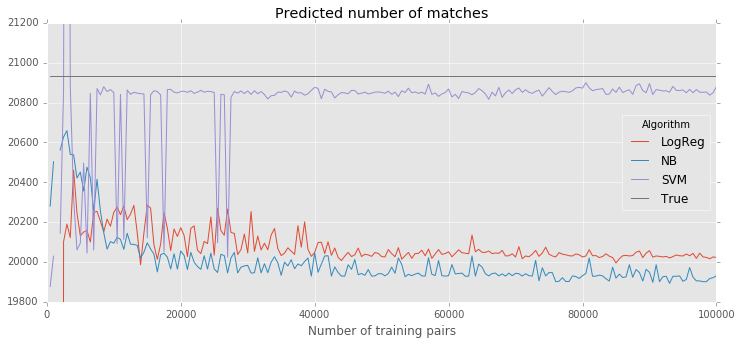

In [26]:
results = pd.DataFrame(n_classifiers).T
results.index = n_training+step_size
results.index.name = "Number of training pairs"
results.columns = ['LogReg', 'NB', 'SVM']
results.columns.name = "Algorithm"

results['True'] = len(krebs_match)
results.plot(
    xlim=(0, max(results.index)), 
    ylim=(19800, 21200), 
    figsize=(12,5),
    title="Predicted number of matches"
)